# PRMT-2711 - Cutoff days don't have a large impact on transfer outcomes

## Hypothesis
We believe cutoff days do not have a large impact on transfer outcomes.

## Date Range
February 1st-28th 2022

## Context
We want to setup alerts with closer feedback when errors occur.
In order to do that, we want to understand the changes of transfer outcomes between different cutoff days. For example, we currently run our reports on a 7-day cutoff basis, meaning we get the data up to 8 days after the transfer happens. We want to see if having 0 cut off days (no additional days of data from when the transfer started) has a large affect, and if not, we may be able to report transfers a day after they happen.
For the analysis, we want a line graph comparing a month’s worth of data for Feb with:

* 0 day cutoff
* 1 day cutoff
* 2 day cutoff
* 14 day cutoff

And how the different cutoffs affect the outcomes:
* Integrated on time
* Process failures
* Technical failures

In [6]:
import pandas as pd

def add_leading_zero(num: int) -> str:
    return str(num).zfill(2)

In [7]:
data_folder_1_day_cutoff="s3://prm-gp2gp-transfer-data-preprod/v11/cutoff-1"
transfer_parquet_files_1_day_cutoff_1 = [f"{data_folder_1_day_cutoff}/2022/01/{add_leading_zero(day)}/2022-01-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 32)]
transfer_parquet_files_1_day_cutoff_2 = [f"{data_folder_1_day_cutoff}/2022/02/{add_leading_zero(day)}/2022-02-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 29)]
transfer_parquet_files_1_day_cutoff_3 = [f"{data_folder_1_day_cutoff}/2022/03/{add_leading_zero(day)}/2022-03-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 32)]
transfer_parquet_files_1_day_cutoff_4 = [f"{data_folder_1_day_cutoff}/2022/04/{add_leading_zero(day)}/2022-04-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 31)]
transfer_parquet_files_1_day_cutoff_5 = [f"{data_folder_1_day_cutoff}/2022/05/{add_leading_zero(day)}/2022-05-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 32)]
transfer_parquet_files_1_day_cutoff_6 = [f"{data_folder_1_day_cutoff}/2022/06/{add_leading_zero(day)}/2022-06-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 31)]
transfer_parquet_files_1_day_cutoff_7 = [f"{data_folder_1_day_cutoff}/2022/07/{add_leading_zero(day)}/2022-07-{add_leading_zero(day)}-transfers.parquet" for day in range(1, 20)]
transfers_raw_1_day_cutoff_1 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_1])
transfers_raw_1_day_cutoff_2 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_2])
transfers_raw_1_day_cutoff_3 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_3])
transfers_raw_1_day_cutoff_4 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_4])
transfers_raw_1_day_cutoff_5 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_5])
transfers_raw_1_day_cutoff_6 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_6])
transfers_raw_1_day_cutoff_7 = pd.concat([pd.read_parquet(file) for file in transfer_parquet_files_1_day_cutoff_7])

In [8]:
transfers_raw_1_day_cutoff = pd.concat([transfers_raw_1_day_cutoff_1, transfers_raw_1_day_cutoff_2, transfers_raw_1_day_cutoff_3, transfers_raw_1_day_cutoff_4, transfers_raw_1_day_cutoff_5, transfers_raw_1_day_cutoff_6, transfers_raw_1_day_cutoff_7])

In [9]:
total_transfers = transfers_raw_1_day_cutoff.shape[0]
total_transfers

1344744

# Summary
## 1 day cutoff

In [10]:
one_day = transfers_raw_1_day_cutoff.value_counts("status")
one_day

status
Integrated on time      783091
Process failure         471815
Technical failure        83531
Unclassified failure      6307
dtype: int64

In [11]:
one_day_percentage = transfers_raw_1_day_cutoff.value_counts("status").apply(lambda x: (x / total_transfers)) * 100
one_day_percentage

status
Integrated on time      58.233463
Process failure         35.085860
Technical failure        6.211666
Unclassified failure     0.469011
dtype: float64

In [12]:
transfers_raw_1_day_cutoff['day'] = transfers_raw_1_day_cutoff['date_requested'].dt.to_period('D')
grouped_1_day_transfers = transfers_raw_1_day_cutoff.groupby("day").agg({'conversation_id':'count'}).reset_index()
#grouped_1_day_transfers

In [13]:
technical_failure_1_day_cutoff_bool = transfers_raw_1_day_cutoff["status"] == "Technical failure"
technical_failure_1_day_cutoff_bool = transfers_raw_1_day_cutoff[technical_failure_1_day_cutoff_bool]
grouped_technical_failure_1_day_cutoff = technical_failure_1_day_cutoff_bool.groupby("day").agg({'conversation_id':'count'}).reset_index()
#grouped_technical_failure_1_day_cutoff

In [14]:
merged_grouped_1_day_transfers = grouped_1_day_transfers.merge(grouped_technical_failure_1_day_cutoff, left_on="day", right_on="day", how="outer")
merged_grouped_1_day_transfers['percentage'] = (merged_grouped_1_day_transfers['conversation_id_y'] / merged_grouped_1_day_transfers['conversation_id_x']) * 100

<AxesSubplot:xlabel='day'>

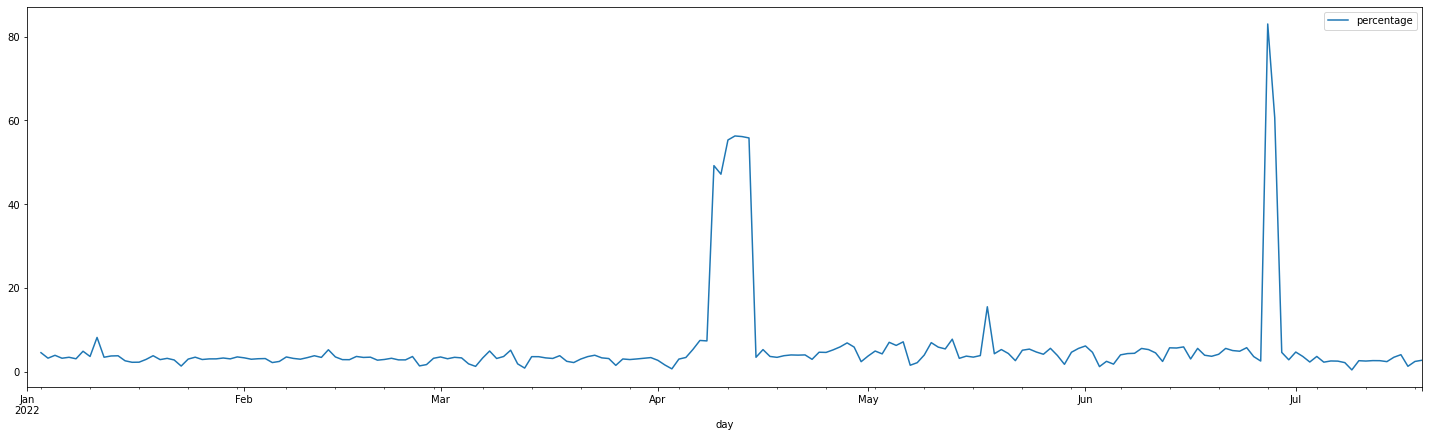

In [15]:
merged_grouped_1_day_transfers.plot(x="day", y="percentage", figsize=(25,7))

In [16]:
merged_grouped_1_day_transfers["percentage"].describe()

count    199.000000
mean       5.903805
std       10.991186
min        0.432900
25%        2.897080
50%        3.472222
75%        4.636691
max       83.013905
Name: percentage, dtype: float64

In [17]:
merged_grouped_1_day_transfers_rounded = merged_grouped_1_day_transfers.copy()
merged_grouped_1_day_transfers_rounded["percentage"] = merged_grouped_1_day_transfers_rounded["percentage"].round(2).fillna(0)

In [18]:
pd.set_option('display.max_rows', 200)
merged_grouped_1_day_transfers_rounded.set_index("day", inplace=True, drop=True)
merged_grouped_1_day_transfers_rounded[["percentage"]]

,percentage
day,
2022-01-01,3.49
2022-01-02,0.00
2022-01-03,4.55
2022-01-04,3.24
2022-01-05,3.92
2022-01-06,3.22
2022-01-07,3.45
2022-01-08,3.09
2022-01-09,4.89


In [19]:
count_of_errors_more_than_5_bool = merged_grouped_1_day_transfers_rounded["percentage"] > 10
merged_grouped_1_day_transfers_rounded[count_of_errors_more_than_5_bool].count()

conversation_id_x    9
conversation_id_y    9
percentage           9
dtype: int64

<AxesSubplot:xlabel='day'>

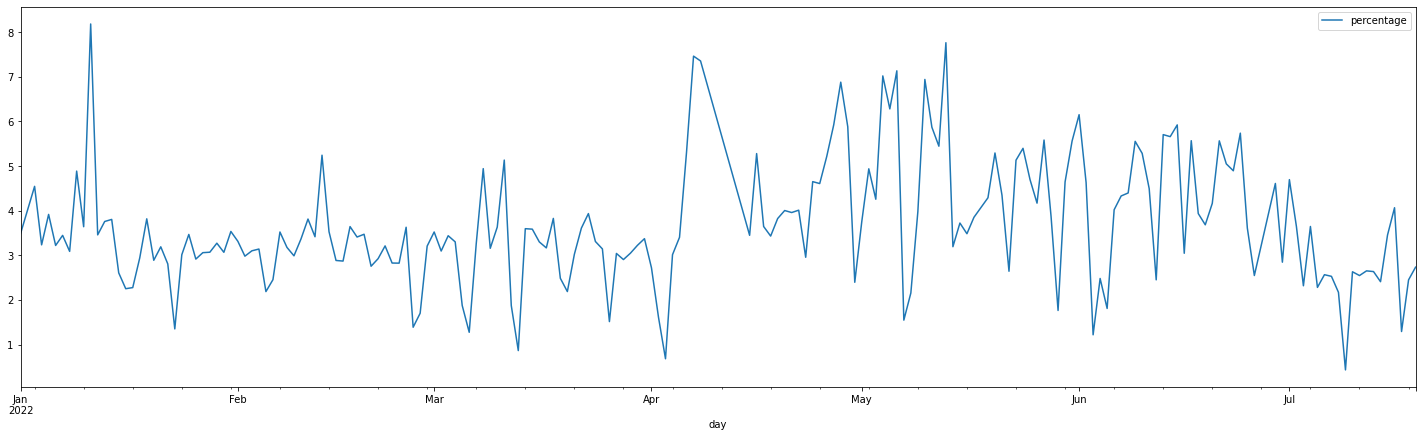

In [20]:
threshold_percent = 10
merged_grouped_1_day_transfers_less_than_threshold_bool = merged_grouped_1_day_transfers["percentage"] < threshold_percent
merged_grouped_1_day_transfers_less_than_threshold = merged_grouped_1_day_transfers[merged_grouped_1_day_transfers_less_than_threshold_bool]
merged_grouped_1_day_transfers_less_than_threshold.plot(x="day", y="percentage", figsize=(25,7))